In [ ]:
%pip install rdkit-pypi tensorflow==2.14.0
%pip install "deepchem>=2.8.0.dev202405"
# %pip install torch --index-url https://download.pytorch.org/whl/cpu

In [ ]:
# %pip uninstall -y torch

### Setup and Dataloading

In [ ]:
# %pip install scikit-learn pandas matplotlib seaborn

In [15]:
import deepchem as dc
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, average_precision_score
)
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load Tox21 dataset using ECFP (Extended-Connectivity Fingerprints)
tasks, datasets, transformers = dc.molnet.load_tox21(featurizer='ECFP')

train_dataset, valid_dataset, test_dataset = datasets

print(f"Tasks: {tasks}")
print(f"Train size: {len(train_dataset)} | Valid size: {len(valid_dataset)} | Test size: {len(test_dataset)}")

Tasks: ['NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER', 'NR-ER-LBD', 'NR-PPAR-gamma', 'SR-ARE', 'SR-ATAD5', 'SR-HSE', 'SR-MMP', 'SR-p53']
Train size: 6264 | Valid size: 783 | Test size: 784


Data Visualization

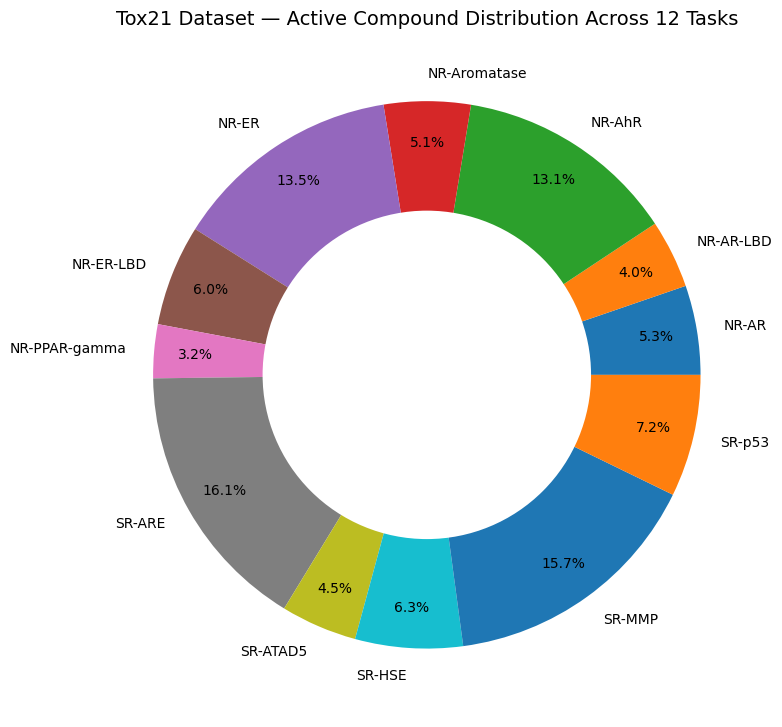

In [ ]:
import os

y_all = np.vstack([train_dataset.y, valid_dataset.y, test_dataset.y])
active_counts = (y_all == 1).sum(axis=0)

os.makedirs("figs", exist_ok=True)

plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(
    active_counts,
    labels=tasks,
    autopct="%1.1f%%",
    pctdistance=0.85,
)

centre_circle = plt.Circle((0,0), 0.60, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title("Tox21 Dataset — Active Compound Distribution Across 12 Tasks", fontsize=14)
plt.tight_layout()
plt.savefig("figs/tox21_task_distribution.png", dpi=300)
plt.show()

### Baseline Models and Results for Task: NR-AR

1. Data Inspection

Selected task: NR-AR
Valid samples for this task: 6264


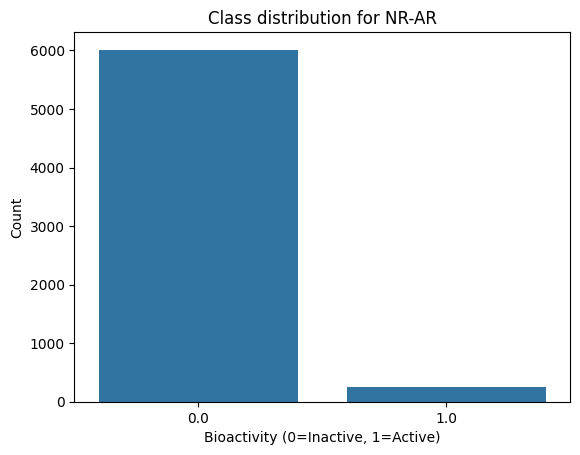

In [ ]:
# Convert DeepChem dataset to Pandas for exploration
X_train = train_dataset.X
y_train = train_dataset.y
mask_train = ~np.isnan(y_train)

# Since Tox21 has multiple tasks, pick one for initial baseline (e.g., 'NR-AR')
target_idx = 0
y_train_task = y_train[:, target_idx]
mask_task = ~np.isnan(y_train_task)

print(f"Selected task: {tasks[target_idx]}")
print(f"Valid samples for this task: {np.sum(mask_task)}")

# Class distribution
sns.countplot(x=y_train_task[mask_task])
plt.title(f"Class distribution for {tasks[target_idx]}")
plt.xlabel("Bioactivity (0=Inactive, 1=Active)")
plt.ylabel("Count")
plt.show()

2. Data Cleaning / Preprocessing

In [4]:
# Keep only valid (non-NaN) samples for the selected task
X_train_task = X_train[mask_task]
y_train_task = y_train_task[mask_task]

# Similarly prepare validation and test data
y_valid_task = valid_dataset.y[:, target_idx]
mask_valid = ~np.isnan(y_valid_task)
X_valid_task = valid_dataset.X[mask_valid]
y_valid_task = y_valid_task[mask_valid]

y_test_task = test_dataset.y[:, target_idx]
mask_test = ~np.isnan(y_test_task)
X_test_task = test_dataset.X[mask_test]
y_test_task = y_test_task[mask_test]

print(f"Train shape: {X_train_task.shape}, Valid shape: {X_valid_task.shape}, Test shape: {X_test_task.shape}")

# Scaling (for SVM; RF is scale-invariant)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_task)
X_valid_scaled = scaler.transform(X_valid_task)
X_test_scaled = scaler.transform(X_test_task)

Train shape: (6264, 1024), Valid shape: (783, 1024), Test shape: (784, 1024)


3. Random Forest

In [5]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    n_jobs=-1,
    random_state=42
)
rf.fit(X_train_task, y_train_task)

rf_preds = rf.predict(X_test_task)
rf_probs = rf.predict_proba(X_test_task)[:, 1]

rf_results = {
    "Accuracy": accuracy_score(y_test_task, rf_preds),
    "Precision": precision_score(y_test_task, rf_preds),
    "Recall": recall_score(y_test_task, rf_preds),
    "F1": f1_score(y_test_task, rf_preds),
    "ROC-AUC": roc_auc_score(y_test_task, rf_probs),
    "PR-AUC": average_precision_score(y_test_task, rf_probs)
}

print("=== Random Forest Results ===")
for k, v in rf_results.items():
    print(f"{k}: {v:.4f}")

=== Random Forest Results ===
Accuracy: 0.9707
Precision: 0.6667
Recall: 0.2963
F1: 0.4103
ROC-AUC: 0.7441
PR-AUC: 0.3468


4. SVM

In [6]:
svm = SVC(
    kernel='rbf',
    probability=True,
    class_weight='balanced',  # handles class imbalance
    random_state=42
)
svm.fit(X_train_scaled, y_train_task)

svm_preds = svm.predict(X_test_scaled)
svm_probs = svm.predict_proba(X_test_scaled)[:, 1]

svm_results = {
    "Accuracy": accuracy_score(y_test_task, svm_preds),
    "Precision": precision_score(y_test_task, svm_preds),
    "Recall": recall_score(y_test_task, svm_preds),
    "F1": f1_score(y_test_task, svm_preds),
    "ROC-AUC": roc_auc_score(y_test_task, svm_probs),
    "PR-AUC": average_precision_score(y_test_task, svm_probs)
}

print("=== SVM Results ===")
for k, v in svm_results.items():
    print(f"{k}: {v:.4f}")

=== SVM Results ===
Accuracy: 0.9630
Precision: 0.2500
Recall: 0.0370
F1: 0.0645
ROC-AUC: 0.6357
PR-AUC: 0.1628


5. Comparison Plot

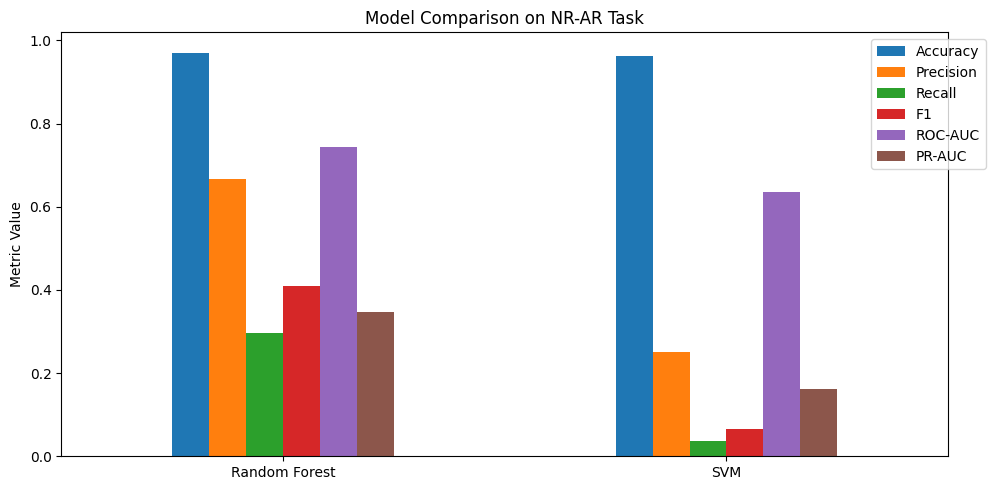

In [7]:
results_df = pd.DataFrame([rf_results, svm_results], index=["Random Forest", "SVM"])
results_df.plot(kind='bar', figsize=(10,5))
plt.title(f"Model Comparison on {tasks[target_idx]} Task")
plt.ylabel("Metric Value")
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

### Baseline Script for all TOX21 Tasks

In [2]:
from task_trainer import run_all_tasks

# Run all tasks and collect results
results_df = run_all_tasks(tasks, train_dataset, test_dataset, max_workers=4)

# Display summary
print("\nBaseline training complete!")
print(results_df.groupby("Model")[["ROC-AUC", "PR-AUC", "F1", "Accuracy"]].mean())


Launching parallel training across 4 workers...

Results saved to results/tox21_baseline_results.csv

All plots saved in results/plots/

Baseline training complete!
                ROC-AUC    PR-AUC        F1  Accuracy
Model                                                
Random Forest  0.689495  0.232358  0.137645  0.929847
SVM            0.676948  0.201932  0.110721  0.926552


### Optimized Script for ML Models (for select TOX21 tasks)

In [ ]:
from optimized_pipeline import main

results_df = main()

# Display summary
print("\nOptimized training complete!")
print(results_df.groupby("Model")[["ROC-AUC", "PR-AUC", "F1", "Accuracy", "Precision"]].mean())

Skipped loading some Pytorch utilities, missing a dependency. No module named 'torch'


This module requires PyTorch to be installed.


Skipped loading some PyTorch models, missing a dependency. No module named 'torch'
No module named 'torch'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch'
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'torch'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


Loading Tox21 dataset...
Total tasks: 12
Running 4 tasks: ['NR-AR', 'NR-ER', 'SR-HSE', 'SR-p53']

Starting task: NR-AR

Starting task: NR-ER

Starting task: SR-HSE

Starting task: SR-p53


[I 2025-10-28 21:17:38,920] A new study created in memory with name: no-name-27a55751-f2e3-4f6d-ac9c-bbe897c2b9e1
[I 2025-10-28 21:17:39,811] A new study created in memory with name: no-name-4a73a0f6-505b-40d3-8e17-f46c626b408f
[I 2025-10-28 21:17:39,850] A new study created in memory with name: no-name-675d1837-e256-4b93-85ed-2e89161809a4
[I 2025-10-28 21:17:39,851] A new study created in memory with name: no-name-bf8fea3f-4761-449e-9579-6417d2f717d0
[I 2025-10-28 21:17:46,089] Trial 0 finished with value: 0.6504519774011299 and parameters: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 0 with value: 0.6504519774011299.
[I 2025-10-28 21:17:46,501] Trial 0 finished with value: 0.6933509656784352 and parameters: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 0 with value: 0.6933509656784352.
[I 2025-10-28 21:17:46,540] Trial 0 finish

SHAP failed for NR-ER: 'utf-8' codec can't decode byte 0xae in position 242: invalid start byte


[I 2025-10-28 21:23:24,017] Trial 6 finished with value: 0.6989943412473859 and parameters: {'n_estimators': 343, 'max_depth': 4, 'learning_rate': 0.012151617026673379, 'subsample': 0.9795542149013333, 'colsample_bytree': 0.9862528132298237}. Best is trial 2 with value: 0.7394513470291548.
[I 2025-10-28 21:23:33,764] Trial 7 finished with value: 0.6933709981167608 and parameters: {'n_estimators': 424, 'max_depth': 4, 'learning_rate': 0.013399060561509796, 'subsample': 0.8736932106048627, 'colsample_bytree': 0.7760609974958406}. Best is trial 2 with value: 0.7357815442561205.


SHAP failed for NR-AR: 'utf-8' codec can't decode byte 0x80 in position 502: invalid start byte
SHAP failed for SR-p53: 'utf-8' codec can't decode byte 0xbb in position 766: invalid start byte


[I 2025-10-28 21:24:09,446] Trial 7 finished with value: 0.7158937138639438 and parameters: {'n_estimators': 424, 'max_depth': 4, 'learning_rate': 0.013399060561509796, 'subsample': 0.8736932106048627, 'colsample_bytree': 0.7760609974958406}. Best is trial 2 with value: 0.7394513470291548.


SHAP failed for SR-HSE: 'utf-8' codec can't decode byte 0x81 in position 765: invalid start byte

Results saved at results/tox21_optimized_results.csv
\Optimized training complete!
                ROC-AUC    PR-AUC        F1  Accuracy  Precision
Model                                                           
RF_Baseline    0.681495  0.278214  0.162134  0.933355   0.698077
RF_Optimized   0.721479  0.303696  0.262737  0.926339   0.528182
XGB_Optimized  0.722557  0.308691  0.237516  0.931441   0.534736


### DL Model for TOX21 Tasks (GNN)

In [ ]:
# requirements:-

# %pip install torch==2.1.0 --index-url https://download.pytorch.org/whl/cpu
# %pip install dgl==1.1.2
# %pip install dgllife==0.3.2

1. Baseline GNN Model (GraphConv - Duvenaud, David K., et al 2015)

In [1]:
from gnn_tox21_graphconv import train_gnn_tox21

results = train_gnn_tox21(epochs=30)
results

Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with transformers dependency. No module named 'transformers'
cannot import name 'HuggingFaceModel' from 'deepchem.models.torch_models' (c:\Users\sayya\AppData\Local\Programs\Python\Python311\Lib\site-packages\deepchem\models\torch_models\__init__.py)
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (c:\Users\sayya\AppData\Local\Programs\Python\Python311\Lib\site-packages\deepchem\models\torch_models\__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


Loading Tox21 dataset...
Dataset loaded.
Tasks: ['NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER', 'NR-ER-LBD', 'NR-PPAR-gamma', 'SR-ARE', 'SR-ATAD5', 'SR-HSE', 'SR-MMP', 'SR-p53']
Training on: cpu

Initializing GraphConv GNN model...
Training started...

Evaluating model...


,Model,Task,Split,ROC-AUC,PR-AUC
0,GraphConv,NR-AR,VALID,0.752960,0.417683
1,GraphConv,NR-AR-LBD,VALID,0.857520,0.431851
2,GraphConv,NR-AhR,VALID,0.822962,0.428922
3,GraphConv,NR-Aromatase,VALID,0.738753,0.167724
4,GraphConv,NR-ER,VALID,0.645104,0.263819
5,GraphConv,NR-ER-LBD,VALID,0.714077,0.293463
6,GraphConv,NR-PPAR-gamma,VALID,0.770098,0.180463
7,GraphConv,SR-ARE,VALID,0.628968,0.182442
8,GraphConv,SR-ATAD5,VALID,0.712529,0.170171
9,GraphConv,SR-HSE,VALID,0.729764,0.154875


2. Upgrade: GAT Model (GNN - Veličković et al., 2018)

In [1]:
from gnn_tox21_GAT import train_gnn_tox21

gat_results = train_gnn_tox21(epochs=50)  # GAT benefits from slightly more epochs
gat_results

Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with transformers dependency. No module named 'transformers'
cannot import name 'HuggingFaceModel' from 'deepchem.models.torch_models' (c:\Users\sayya\AppData\Local\Programs\Python\Python311\Lib\site-packages\deepchem\models\torch_models\__init__.py)
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (c:\Users\sayya\AppData\Local\Programs\Python\Python311\Lib\site-packages\deepchem\models\torch_models\__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


Loading Tox21 dataset...
Dataset loaded.
Tasks: ['NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER', 'NR-ER-LBD', 'NR-PPAR-gamma', 'SR-ARE', 'SR-ATAD5', 'SR-HSE', 'SR-MMP', 'SR-p53']

Initializing GAT Model (Graph Attention Network)...
GAT model initialized. Training on CPU...

Evaluating model...


[['GraphConv', 'NR-AR', 'VALID', 0.7843440860215053, 0.26990161461882134],
 ['GraphConv', 'NR-AR-LBD', 'VALID', 0.8619047619047618, 0.39256169567603616],
 ['GraphConv', 'NR-AhR', 'VALID', 0.8168124151180893, 0.4035239546285899],
 ['GraphConv',
  'NR-Aromatase',
  'VALID',
  0.7315217391304348,
  0.1485247002075315],
 ['GraphConv', 'NR-ER', 'VALID', 0.6441926345609066, 0.21487691670659675],
 ['GraphConv', 'NR-ER-LBD', 'VALID', 0.7720561261922231, 0.2452999959677637],
 ['GraphConv',
  'NR-PPAR-gamma',
  'VALID',
  0.7709237316421894,
  0.23976671123483023],
 ['GraphConv', 'SR-ARE', 'VALID', 0.6953648915187377, 0.2650001336960735],
 ['GraphConv', 'SR-ATAD5', 'VALID', 0.6858291842206052, 0.10688264529577311],
 ['GraphConv', 'SR-HSE', 'VALID', 0.7813858952543014, 0.17359040699742143],
 ['GraphConv', 'SR-MMP', 'VALID', 0.7855846091315539, 0.34042202670587735],
 ['GraphConv', 'SR-p53', 'VALID', 0.699395656279509, 0.1844455385545121],
 ['GraphConv', 'NR-AR', 'TEST', 0.7196958547951925, 0.18747

In [3]:
import pandas as pd

for f in [
    "results/tox21_baseline_results.csv",
    "results/tox21_optimized_results.csv",
    "results/tox21_gnn_results_graphconv.csv",
    "results/tox21_gnn_results_GAT.csv"
]:
    print("\n-----", f, "-----")
    df = pd.read_csv(f)
    print(df.head())
    print(df.columns)



----- results/tox21_baseline_results.csv -----
           Task          Model  Accuracy  Precision    Recall        F1  \
0     NR-AR-LBD  Random Forest  0.975765   0.500000  0.210526  0.296296   
1     NR-AR-LBD            SVM  0.973214   0.000000  0.000000  0.000000   
2  NR-Aromatase  Random Forest  0.941327   0.600000  0.063830  0.115385   
3  NR-Aromatase            SVM  0.941327   0.571429  0.085106  0.148148   
4         NR-AR  Random Forest  0.970663   0.666667  0.296296  0.410256   

    ROC-AUC    PR-AUC  Train Time (s)  
0  0.812797  0.275271       15.947359  
1  0.863020  0.205570       83.486935  
2  0.684258  0.230435       15.887170  
3  0.640434  0.176756      110.921627  
4  0.744117  0.346769       16.337726  
Index(['Task', 'Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC',
       'PR-AUC', 'Train Time (s)'],
      dtype='object')

----- results/tox21_optimized_results.csv -----
   Accuracy  Precision    Recall        F1   ROC-AUC    PR-AUC   Task  \
0  0.

### Results (plots and tables)

In [6]:
import pandas as pd
import glob
import os

def compute_mean_metrics(input_folder=".", output_csv="results/tox21_mean_results.csv"):
    """
    Reads all result CSV files inside a folder and computes mean metrics.
    Expected CSV columns:
       Task, Model, Accuracy, Precision, Recall, F1, ROC-AUC, PR-AUC, Train Time (s)
    """

    # Read all CSVs in the folder
    csv_files = glob.glob(os.path.join(input_folder, "*.csv"))

    combined_df = pd.DataFrame()

    for file in csv_files:
        df = pd.read_csv(file)
        
        # Ensure required columns exist
        required_cols = ["Task", "Model", "Accuracy", "Precision", "Recall",
                         "F1", "ROC-AUC", "PR-AUC", "Train Time (s)"]
        df = df[[c for c in required_cols if c in df.columns]]

        combined_df = pd.concat([combined_df, df], ignore_index=True)

    # Group by model and compute mean of numeric metrics
    mean_df = combined_df.groupby("Model").agg({
        "Accuracy": "mean",
        "Precision": "mean",
        "Recall": "mean",
        "F1": "mean",
        "ROC-AUC": "mean",
        "PR-AUC": "mean",
        "Train Time (s)": "mean"
    }).reset_index()

    # Save result
    mean_df.to_csv(output_csv, index=False)


In [7]:
compute_mean_metrics("results")

Results - Optimized Models (RF & XGBoost)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

RESULTS_FOLDER = "results/plots"
os.makedirs(RESULTS_FOLDER, exist_ok=True)

csv_file = "results/tox21_optimized_results.csv"
df = pd.read_csv(csv_file)

mean_df = df.groupby("Model")[["Accuracy", "Precision", "Recall", "F1", "ROC-AUC", "PR-AUC"]].mean()
mean_df.reset_index(inplace=True)

print("\nMean Metrics Per Model:\n")
print(mean_df)


plt.figure(figsize=(12, 6))
mean_df_melt = mean_df.melt(id_vars="Model", var_name="Metric", value_name="Score")

sns.barplot(data=mean_df_melt, x="Metric", y="Score", hue="Model", palette="viridis")

plt.title("Mean Performance Metrics Across Models", fontsize=14)
plt.ylabel("Mean Score")
plt.xticks(rotation=45)
plt.tight_layout()

save_path = f"{RESULTS_FOLDER}/mean_metric_summary.png"
plt.savefig(save_path, dpi=300)
plt.close()

print(f"\n Plot saved at: {save_path}")



Mean Metrics Per Model:

           Model  Accuracy  Precision    Recall        F1   ROC-AUC    PR-AUC
0    RF_Baseline  0.933355   0.698077  0.109783  0.162134  0.681495  0.278214
1   RF_Optimized  0.926339   0.528182  0.201204  0.262737  0.721479  0.303696
2  XGB_Optimized  0.931441   0.534736  0.170119  0.237516  0.722557  0.308691

 Plot saved at: results/plots/mean_metric_summary.png


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

df = pd.read_csv("results/tox21_optimized_results.csv")

os.makedirs("results/plots", exist_ok=True)

mean_df = (
    df.groupby("Model")[["Accuracy", "Precision", "Recall", "F1", "ROC-AUC", "PR-AUC"]]
    .mean()
    .reset_index()
)

baseline = mean_df[mean_df["Model"] == "RF_Baseline"].iloc[0]
rf_opt = mean_df[mean_df["Model"] == "RF_Optimized"].iloc[0]
xgb_opt = mean_df[mean_df["Model"] == "XGB_Optimized"].iloc[0]

delta_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1", "ROC-AUC", "PR-AUC"],
    "RF_Improvement (percentage increment)": (rf_opt[1:].values - baseline[1:].values)/baseline[1:].values*100,
    "XGB_Improvement (percentage increment)": (xgb_opt[1:].values - baseline[1:].values)/baseline[1:].values*100
})

delta_df.to_csv("results/optimized_delta_table.csv", index=False)

print("\nDelta improvement table saved at:")
print("results/optimized_delta_table.csv")

plt.figure(figsize=(8, 5))
sns.barplot(
    data=mean_df,
    x="Model",
    y="Recall",
    palette="viridis"
)
plt.title("Recall Comparison (Higher Recall = More Actives Detected)")
plt.ylabel("Mean Recall")
plt.tight_layout()
plt.savefig("results/plots/recall_comparison.png", dpi=300)
plt.close()

plt.figure(figsize=(8, 5))
sns.barplot(
    data=mean_df,
    x="Model",
    y="Precision",
    palette="magma"
)
plt.title("Precision Comparison (Precision/Recall Tradeoff Insight)")
plt.ylabel("Mean Precision")
plt.tight_layout()
plt.savefig("results/plots/precision_comparison.png", dpi=300)
plt.close()

print("\nSaved plots:")
print("results/plots/recall_comparison.png")
print("results/plots/precision_comparison.png")


Delta improvement table saved at:
results/optimized_delta_table.csv


C:\Users\sayya\AppData\Local\Temp\ipykernel_22820\4018122751.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\sayya\AppData\Local\Temp\ipykernel_22820\4018122751.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(



Saved plots:
results/plots/recall_comparison.png
results/plots/precision_comparison.png


Results - DL Model (GraphConv and GAT)

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

input_mean_csv = "results/tox21_mean_results.csv"
graphconv_csv = "results/tox21_gnn_results_graphconv.csv"
gat_csv = "results/tox21_gnn_results_GAT.csv"
output_folder = "results/plots"
os.makedirs(output_folder, exist_ok=True)

mean_df = pd.read_csv(input_mean_csv)
df_graphconv = pd.read_csv(graphconv_csv)
df_gat = pd.read_csv(gat_csv)

graphconv_test = df_graphconv[df_graphconv["Split"] == "TEST"]
gat_test = df_gat[df_gat["Split"] == "TEST"]

merged = graphconv_test.merge(
    gat_test,
    on="Task",
    suffixes=("_GraphConv", "_GAT")
)

mean_df = mean_df[["Model", "ROC-AUC", "PR-AUC"]]
mean_df = mean_df.round(4) 
print("Mean Results - metrics: ROC-AUC, PR-AUC (All Models):\n")
print(mean_df)

plt.figure(figsize=(12, 6))
# sns.lineplot(
#     data=merged, x="Task", y="ROC-AUC_GraphConv",
#     marker="o", label="GraphConv"
# )
# sns.lineplot(
#     data=merged, x="Task", y="ROC-AUC_GAT",
#     marker="o", label="GAT"
# )

# plt.xticks(rotation=45)
# plt.title("Per-task ROC-AUC: GraphConv vs GAT (TEST split)")
# plt.ylabel("ROC-AUC")
# plt.xlabel("Tox21 Task")
# plt.tight_layout()

# plot_path = f"{output_folder}/gnn_per_task_rocauc.png"
# plt.savefig(plot_path, dpi=300)
# plt.close()

# print(f"Saved per-task ROC-AUC plot: {plot_path}")

sns.lineplot(
    data=merged, x="Task", y="PR-AUC_GraphConv",
    marker="o", label="GraphConv"
)
sns.lineplot(
    data=merged, x="Task", y="PR-AUC_GAT",
    marker="o", label="GAT"
)

plt.xticks(rotation=45)
plt.title("Per-task PR-AUC: GraphConv vs GAT (TEST split)")
plt.ylabel("PR-AUC")
plt.xlabel("Tox21 Task")
plt.tight_layout()

plot_path = f"{output_folder}/gnn_per_task_prauc.png"
plt.savefig(plot_path, dpi=300)
plt.close()

Mean Results - metrics: ROC-AUC, PR-AUC (All Models):

           Model  ROC-AUC  PR-AUC
0  Random Forest   0.6895  0.2324
1            SVM   0.6769  0.2019
2    RF_Baseline   0.6815  0.2782
3   RF_Optimized   0.7215  0.3037
4  XGB_Optimized   0.7226  0.3087
5            GAT   0.7302  0.2185
6      GraphConv   0.7154  0.2517
